In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime

import math
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm
plt.style.use("fivethirtyeight")
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Flatten
import pandas as pd
import numpy as np
from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
from plotly.offline import init_notebook_mode, iplot, iplot_mpl
init_notebook_mode()


Output hidden; open in https://colab.research.google.com to view.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
path='/content/drive/MyDrive/ThuatToan/DeTai_code/Data/HN/'
paths = [f"{path}{filename}" for filename in os.listdir("/content/drive/MyDrive/ThuatToan/DeTai_code/Data/HN/")]
dfs = [pd.read_csv(path) for path in paths]
df = pd.concat(dfs)
df.sort_values(by=['Date (LT)'])
#Xử lý dữ liệu
df.index = np.arange(1, len(df) + 1)
df.drop('Site', axis=1, inplace=True)
df.drop('Parameter', axis=1, inplace=True)
df.drop('NowCast Conc.', axis=1, inplace=True)
df.drop('AQI Category', axis=1, inplace=True)
df.drop('Raw Conc.', axis=1, inplace=True)
df.drop('Conc. Unit', axis=1, inplace=True)
df.drop('Duration', axis=1, inplace=True)
df.drop('QC Name', axis=1, inplace=True)
df.loc[df['AQI'] <= 0, "AQI"]=0 # nếu AQI <=0 --> 0
df



,Date (LT),Year,Month,Day,Hour,AQI
1,2015-01-01 01:00 AM,2015,1,1,1,0
2,2015-01-01 02:00 AM,2015,1,1,2,0
3,2015-01-01 03:00 AM,2015,1,1,3,0
4,2015-01-01 04:00 AM,2015,1,1,4,0
5,2015-01-01 05:00 AM,2015,1,1,5,0
...,...,...,...,...,...,...
59530,2022-10-31 08:00 PM,2022,10,31,20,107
59531,2022-10-31 09:00 PM,2022,10,31,21,99
59532,2022-10-31 10:00 PM,2022,10,31,22,87
59533,2022-10-31 11:00 PM,2022,10,31,23,73


In [12]:
#df = df.reindex(['Timestamp','Year','Month', 'Day', 'Hour','AQI'], axis=1)
df.rename(columns={'Date (LT)':'Timestamp'}, inplace=True)
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df

,Timestamp,Year,Month,Day,Hour,AQI
1,2015-01-01 01:00:00,2015,1,1,1,0
2,2015-01-01 02:00:00,2015,1,1,2,0
3,2015-01-01 03:00:00,2015,1,1,3,0
4,2015-01-01 04:00:00,2015,1,1,4,0
5,2015-01-01 05:00:00,2015,1,1,5,0
...,...,...,...,...,...,...
59530,2022-10-31 20:00:00,2022,10,31,20,107
59531,2022-10-31 21:00:00,2022,10,31,21,99
59532,2022-10-31 22:00:00,2022,10,31,22,87
59533,2022-10-31 23:00:00,2022,10,31,23,73


In [13]:
df.head()

,Timestamp,Year,Month,Day,Hour,AQI
1,2015-01-01 01:00:00,2015,1,1,1,0
2,2015-01-01 02:00:00,2015,1,1,2,0
3,2015-01-01 03:00:00,2015,1,1,3,0
4,2015-01-01 04:00:00,2015,1,1,4,0
5,2015-01-01 05:00:00,2015,1,1,5,0


In [14]:
df['Date']=df["Timestamp"].dt.date

# Visualization

* Time series by days

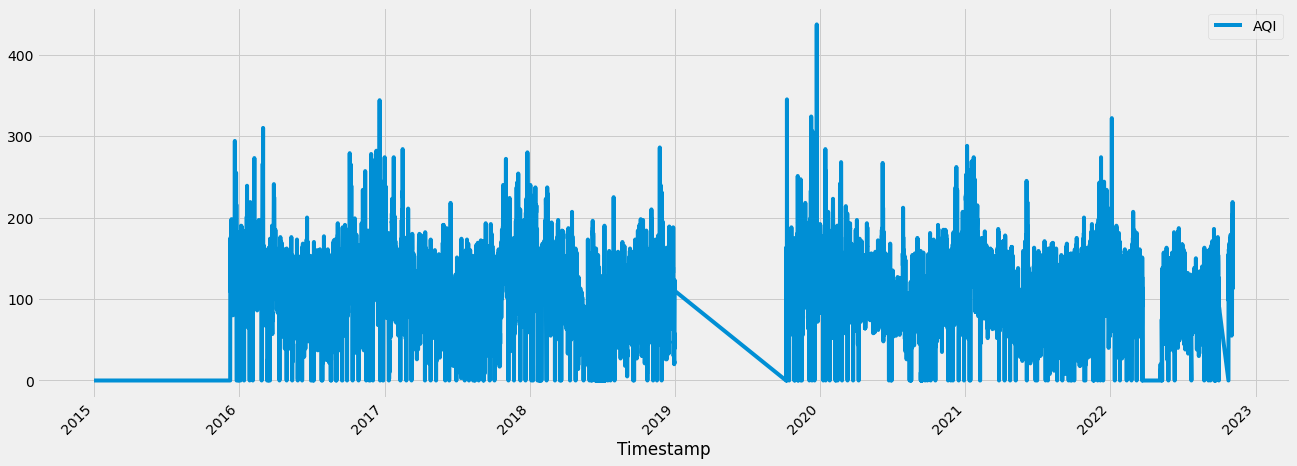

In [16]:
df.plot(x='Timestamp',y='AQI',figsize=(20,8))
plt.xticks(rotation=45)
plt.show()

* Time series by year average

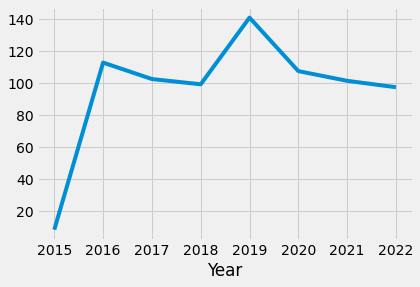

In [18]:
df.groupby('Year')['AQI'].mean().plot()

* Boxplot by year

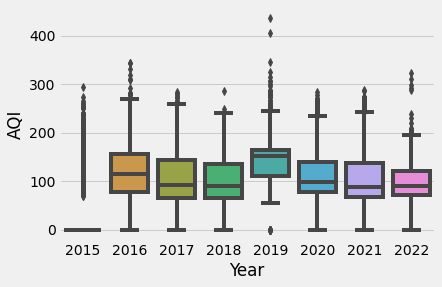

In [20]:
df_year=df.loc[:,['Year','AQI']]
sns.boxplot(x='Year', y='AQI',data=df_year)

* Time series by month average

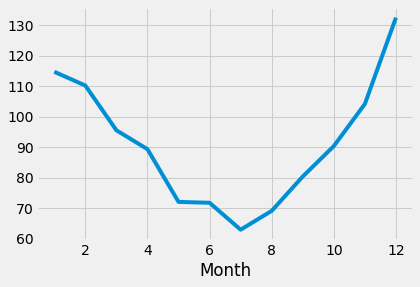

In [21]:
df.groupby('Month')['AQI'].mean().plot()

* Boxplot by month

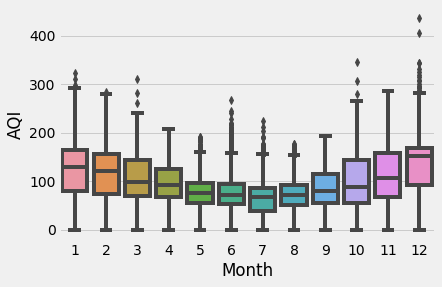

In [22]:
df_month=df.loc[:,['Month','AQI']]
sns.boxplot(x='Month', y='AQI',data=df_month)

* Time series by day average

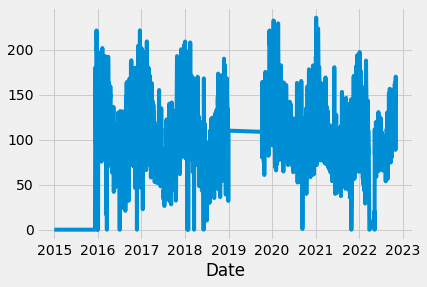

In [24]:
df.groupby('Date')['AQI'].mean().plot()

* Boxplot by day

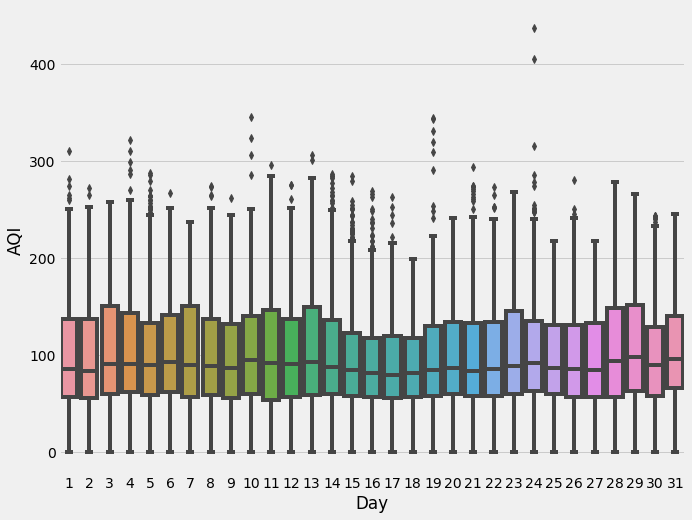

In [26]:
df_day=df.loc[:,['Day','AQI']]
plt.figure(figsize=(10,8))
sns.boxplot(x='Day', y='AQI',data=df_day)

* Time series by hour average

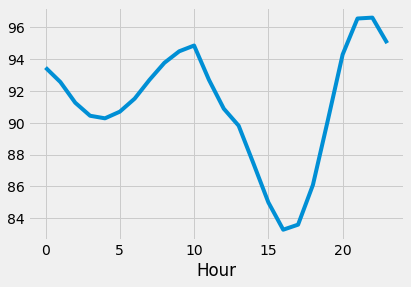

In [25]:
df.groupby('Hour')['AQI'].mean().plot()

* Boxplot by hour

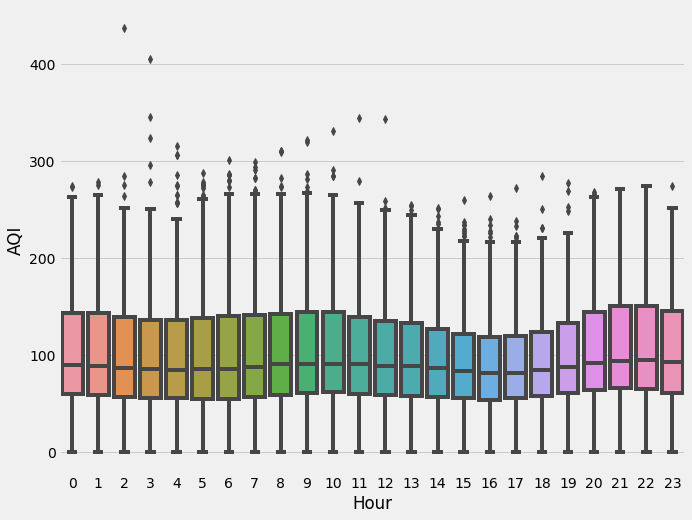

In [27]:
df_hour=df.loc[:,['Hour','AQI']]
plt.figure(figsize=(10,8))
sns.boxplot(x='Hour', y='AQI',data=df_hour)

# Prediction Model - Mô Hình Dự Báo

* I tried to find the prediction model by each days average. So first, I made each days average data set.

In [30]:
df_date=pd.DataFrame(df.groupby('Date')['AQI'].mean())
df_date

,AQI
Date,
2015-01-01,0.000000
2015-01-02,0.000000
2015-01-03,0.000000
2015-01-04,0.000000
2015-01-05,0.000000
...,...
2022-11-01,88.625000
2022-11-02,138.458333
2022-11-03,169.916667


* Time series by each days average

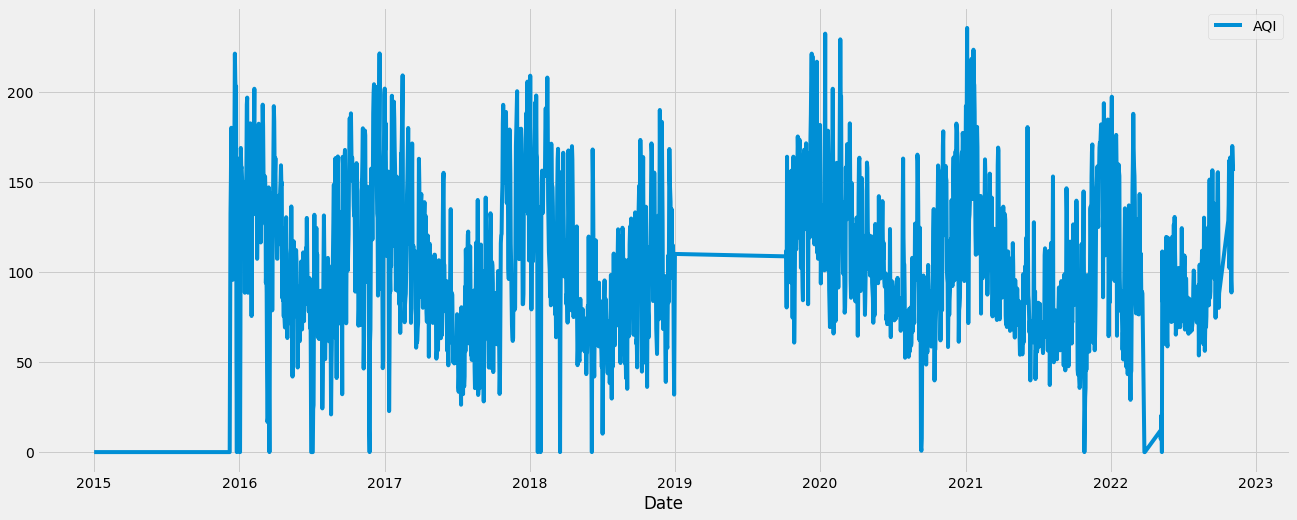

In [31]:
df_date.plot(figsize=(20,8))

* Split data into train 80% and test 20%

In [32]:
dataset  = df_date.values
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

2011

* Standardization by MinMaxScaler

In [33]:
sc = MinMaxScaler(feature_range=(0,1))
scaled_data = sc.fit_transform(dataset)
scaled_data

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.72164219],
       [0.6903203 ],
       [0.6625376 ]])

In [47]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []
len(train_data)
num = 60
for i in range(num, len(train_data)):
    x_train.append(train_data[i-num:i , 0])
    y_train.append(train_data[i , 0])    

In [35]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1951, 60, 1)

* Modeling

In [36]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [37]:
model.compile(optimizer = "adam", loss = "mean_squared_error")

In [ ]:
model.fit(x_train,y_train, batch_size=100, epochs=1)

2022-11-01 02:02:34.728926: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


15/15 [==============================] - 6s 124ms/step - loss: 0.0262


* Prediction (dự báo)

In [38]:
test_data = scaled_data[training_data_len-60: , :]
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(num, len(test_data)):
      x_test.append(test_data[i-num:i, 0])

In [39]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [40]:
predictions = model.predict(x_test)
predictions = sc.inverse_transform(predictions)

16/16 [==============================] - 2s 24ms/step


In [41]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

92.38105900522217

In [42]:
train = df_date[:training_data_len]
valid = df_date[training_data_len:]
valid["Predictions"] = predictions
valid

,AQI,Predictions
Date,,
2021-04-18,111.375000,1.317780
2021-04-19,87.875000,1.184761
2021-04-20,71.041667,1.112017
2021-04-21,72.750000,1.110751
2021-04-22,72.625000,1.120591
...,...,...
2022-11-01,88.625000,0.940599
2022-11-02,138.458333,1.101774
2022-11-03,169.916667,1.096533


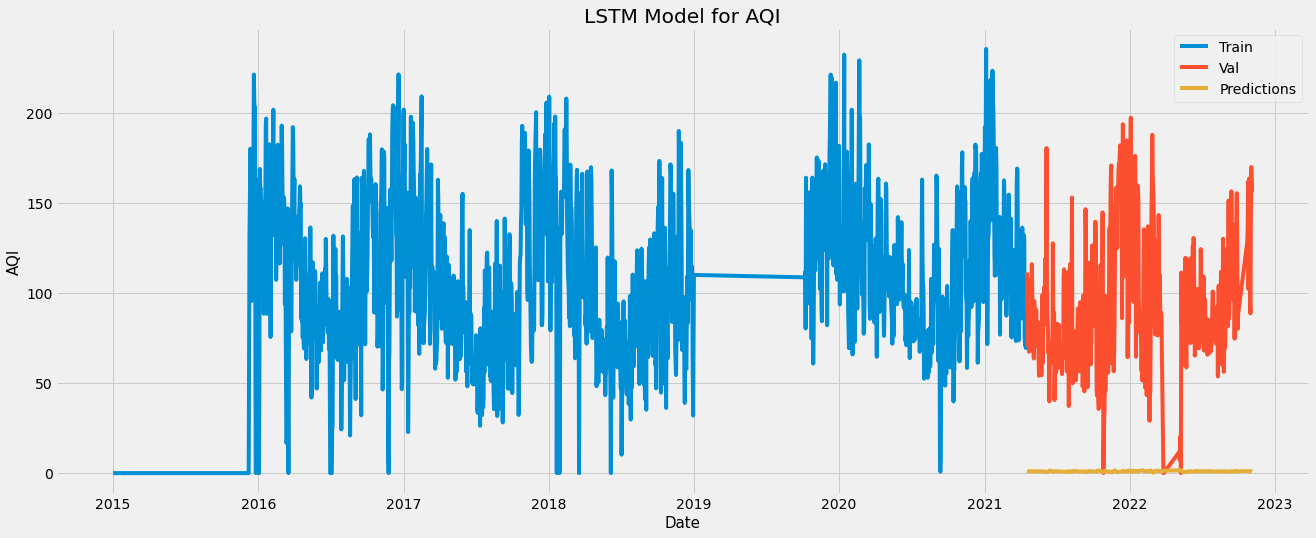

In [44]:
plt.figure(figsize=(20,8))
plt.title("LSTM Model for AQI")
plt.xlabel("Date", fontsize = 15)
plt.ylabel("AQI",fontsize=15)
plt.plot(train[df_date.columns])
plt.plot(valid['AQI'])
plt.plot(valid["Predictions"])
plt.legend(["Train","Val","Predictions"])